# マッチング
どの2辺も同じ頂点に接続しないとき、Mをマッチングという。マッチングの数が最大になる条件を求めるのが最大マッチング問題である。

elbs: {((0, 0), (1, 0)): 1, ((0, 0), (0, 1)): 9, ((0, 1), (1, 1)): 4, ((0, 1), (0, 2)): 4, ((0, 2), (1, 2)): 6, ((1, 0), (2, 0)): 8, ((1, 0), (1, 1)): 1, ((1, 1), (2, 1)): 7, ((1, 1), (1, 2)): 9, ((1, 2), (2, 2)): 1, ((2, 0), (2, 1)): 5, ((2, 1), (2, 2)): 9}
pos: {(0, 0): (0, 0), (0, 1): (0, 1), (0, 2): (0, 2), (1, 0): (1, 0), (1, 1): (1, 1), (1, 2): (1, 2), (2, 0): (2, 0), (2, 1): (2, 1), (2, 2): (2, 2)}
M: {((0, 2), (1, 2)), ((0, 0), (1, 0)), ((2, 0), (2, 1)), ((0, 1), (1, 1))}
MW: {((1, 1), (1, 2)), ((1, 0), (2, 0)), ((2, 1), (2, 2)), ((0, 1), (0, 0))}


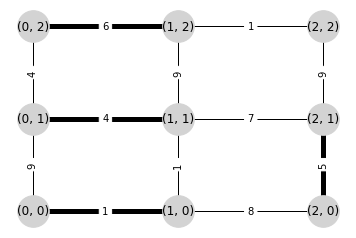

In [1]:
# 最大マッチングを求める
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

G = nx.grid_2d_graph(3,3)
for (u,v) in G.edges():
    G[u][v]['weight'] = np.random.randint(1,10)
elbs = {(u,v):G[u][v]['weight'] for (u,v) in G.edges()}
pos = {v: v for v in G.nodes()}
print('elbs:', elbs)
print('pos:', pos)

M = nx.maximal_matching(G)
print('M:', M)
MW = nx.max_weight_matching(G)
print('MW:', MW)

nx.draw_networkx(G, pos=pos,node_color='lightgrey',
                 node_size=1000, width=1)
nx.draw_networkx_edges(G, pos=pos, edgelist=M, width=5)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=elbs)
plt.axis('off')
plt.show()

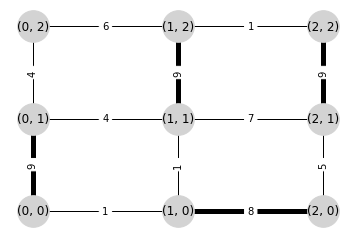

In [2]:
# 重み最大マッチング問題
# 重みも考慮しながら最大マッチングを求める
nx.draw_networkx(G, pos=pos,node_color='lightgrey',node_size=1000, width=1)
nx.draw_networkx_edges(G, pos=pos, edgelist=MW, width=5)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=elbs)
plt.axis('off')
plt.show()

# 辺彩色問題

In [3]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from pulp import *
import itertools
MEPS = 1.0e-8

def edge_coloring(G):
    # 次数の最大値を求める
    delta = max([G.degree(v) for v in G.nodes()])
    k = delta
    solved = False
    
    while not(solved) and k <= delta+1:
        prob = LpProblem(name='Edge_Coloring_by_PuLP', sense=LpMinimize)
    
        x = {(e,i): LpVariable('x'+str(e)+str(',')+str(i),lowBound=0,cat='Binary')
             for e in  G.edges() for i in range(k)}

        prob +=  0     # 目的関数
        
        # 一つの色でぬられている制約
        for e in G.edges:
            prob += lpSum(x[(e,i)] for i in range(k)) == 1
        
        # 色が重複しない制約
        for (u,i) in itertools.product(G.nodes(), range(k)):
            # 頂点uから出ている枝のリスト
            el = [tuple(sorted((u,v))) for v in G.neighbors(u)]
            prob += lpSum(x[(e,i)] for e in el) <= 1

        prob.solve()
        
        # 解けたとき
        if LpStatus[prob.status] == 'Optimal':
            solved =True
        else:
            k += 1

    # 回答を出力
    if solved:
        print('Edge '+str(k)+' coloring found:')
        coloring = {i: [e for e in  G.edges if x[(e,i)].varValue > MEPS] for i in range(k)}
        print(coloring)
    else:
        print("Error:")

In [4]:
G=nx.Graph()
elist = [(1,2),(3,1),(1,4),(4,2), (2,5), (4,3),(3,5)]
G.add_edges_from(elist)
edge_coloring(G)

Edge 4 coloring found:
{0: [(1, 3), (2, 4)], 1: [(1, 2), (3, 5)], 2: [(1, 4)], 3: [(2, 5), (3, 4)]}


In [5]:
K5=nx.complete_graph(5)
edge_coloring(K5)

Edge 5 coloring found:
{0: [(0, 3), (1, 2)], 1: [(1, 4), (2, 3)], 2: [(0, 1), (2, 4)], 3: [(0, 4), (1, 3)], 4: [(0, 2), (3, 4)]}


# 点彩色問題

###### welsh_powellアルゴリズム（近似解）

In [6]:
import random
random.seed(1)
G = nx.random_geometric_graph(50,0.3) # 1辺が1の正方形の中にランダムに点を50個発生させて、距離が0.3以下の時に枝をつける
print('Number of nodes: ',len(G.nodes()))
print('Number of edges: ',len(G.edges()))

Number of nodes:  50
Number of edges:  251


In [7]:
# dequeはpopで最後の要素を取り出すことが可能
collections.deque([0, 1, 2, 3]).pop()

3

In [8]:
# setにはupdateで要素追加可能
a = {1,2,3}
a.update({4})
a

{1, 2, 3, 4}

In [9]:
# 引き算も可能
a = {1,2,3}
a - {1}

{2, 3}

In [10]:
import networkx as nx
import collections

def welsh_powell(G):
    # 最大次数を求める
    delta = max([G.degree(v) for v in G.nodes()])
    
    # 次数の小さい順に頂点を並べ替えたデックを作成
    sv = collections.deque([v for (v,d) in
        sorted(G.degree(), key=lambda x: x[1])])
    
    # 頂点vの周りに使われている色の辞書
    nbcols = {v: set([]) for v in sv}
    # setを作成
    cset = set(range(delta+1))
    print('cset:', cset)
    
    c = min(cset)
    u = sv.pop()
    
    # 次数の大きい頂点の色を確定
    colors = {u: c}
    
    # 頂点vの周りに使われている色として、cを追加
    for v in G.neighbors(u):
        nbcols[v].update({c})
    cls = {c}
    while len(sv) > 0:
        u = sv.pop()
        # 使用できる色のセットを取得し、最小の色で塗る
        c = min(cset-nbcols[u]) 
        colors[u] = c
        # 使用した色のセットをアップデート
        cls.update({c})
        print('cls:', cls)
        # 頂点vの周りに使われている色をアップデート
        for v in G.neighbors(u):
            nbcols[v].update({c})

    print('Node '+str(len(cls))+' coloring found.')

In [11]:
welsh_powell(G)

cset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
cls: {0, 1}
cls: {0, 1, 2}
cls: {0, 1, 2, 3}
cls: {0, 1, 2, 3}
cls: {0, 1, 2, 3, 4}
cls: {0, 1, 2, 3, 4, 5}
cls: {0, 1, 2, 3, 4, 5}
cls: {0, 1, 2, 3, 4, 5}
cls: {0, 1, 2, 3, 4, 5}
cls: {0, 1, 2, 3, 4, 5}
cls: {0, 1, 2, 3, 4, 5}
cls: {0, 1, 2, 3, 4, 5, 6}
cls: {0, 1, 2, 3, 4, 5, 6}
cls: {0, 1, 2, 3, 4, 5, 6}
cls: {0, 1, 2, 3, 4, 5, 6}
cls: {0, 1, 2, 3, 4, 5, 6}
cls: {0, 1, 2, 3, 4, 5, 6, 7}
cls: {0, 1, 2, 3, 4, 5, 6, 7}
cls: {0, 1, 2, 3, 4, 5, 6, 7}
cls: {0, 1, 2, 3, 4, 5, 6, 7}
cls: {0, 1, 2, 3, 4, 5, 6, 7}
cls: {0, 1, 2, 3, 4, 5, 6, 7}
cls: {0, 1, 2, 3, 4, 5, 6, 7}
cls: {0, 1, 2, 3, 4, 5, 6, 7}
cls: {0, 1, 2, 3, 4, 5, 6, 7}
cls: {0, 1, 2, 3, 4, 5, 6, 7}
cls: {0, 1, 2, 3, 4, 5, 6, 7, 8}
cls: {0, 1, 2, 3, 4, 5, 6, 7, 8}
cls: {0, 1, 2, 3, 4, 5, 6, 7, 8}
cls: {0, 1, 2, 3, 4, 5, 6, 7, 8}
cls: {0, 1, 2, 3, 4, 5, 6, 7, 8}
cls: {0, 1, 2, 3, 4, 5, 6, 7, 8}
cls: {0, 1, 2, 3, 4, 5, 6, 7, 8}
cls: {0, 1, 2, 3, 4, 5, 6, 7,

###### 線形最適化として解く
色の数が、近似解よりも一つ小さい

In [12]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from pulp import *
import itertools
MEPS = 1.0e-8

def node_coloring_by_PuLP(G):
    # 最大次数を取得
    delta = max([G.degree(v) for v in G.nodes()])+1
    
    prob = LpProblem(name='Node_Coloring_by_PuLP', sense=LpMinimize)
    y = {k: LpVariable('y'+str(k), lowBound=0, cat='Binary') for k in range(delta)}
    x = {(i, k): LpVariable('x'+str(i)+str(',')+str(k), lowBound=0, cat='Binary')
             for i in  G.nodes() for k in range(delta)}
    
    # 色の数が目的関数
    prob += lpSum(y[k] for k in range(delta))
    
    # 利用されていない色では塗られない
    for i,k in itertools.product(G.nodes(), range(delta)):
        prob += x[i,k] <= y[k]
    # 隣接する頂点が同じ色では塗られない
    for (i,j), k in itertools.product(G.edges(), range(delta)):
        prob += x[i,k]+x[j,k] <= 1
    # 各頂点はどれかの色で塗られている
    for i in G.nodes():
        prob += lpSum(x[i,k] for k in range(delta)) == 1
    
    prob.solve()
    if LpStatus[prob.status] == 'Optimal':
        print('Node '+str(int(value(prob.objective)))+' coloring found.')
    else:
        print("Error:")

In [13]:
node_coloring_by_PuLP(G)

Node 8 coloring found.
